# [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

## Parallel node fan-out and fan-in


In [3]:
import operator
from typing import Annotated, Sequence, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}

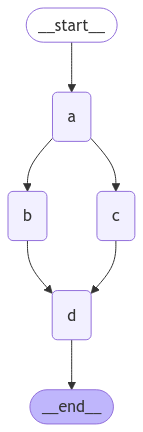

In [4]:
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Parallel node fan-out and fan-in with extra steps

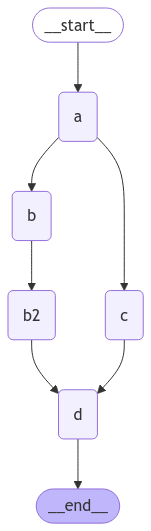

In [6]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "b2")
# builder.add_edge("b2", "d")
# builder.add_edge("c", "d")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("a", "c")
builder.add_edge("d", END)


graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Conditional Branching


In [8]:
class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    which: str


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}

def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]

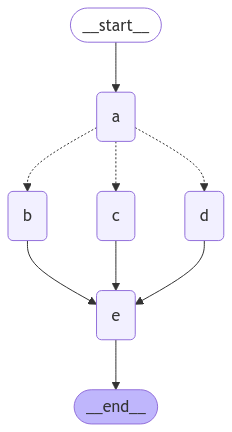

In [9]:
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))

builder.add_edge(START, "a")
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)
for node in intermediates:
    builder.add_edge(node, "e")
builder.add_edge("e", END)
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm E to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm E"], 'which': 'bc'}

In [11]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}

## Stable Sorting

In [14]:
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # Overwrite
        return []
    return left + right

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str

class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }
    
def aggregate_fanout_values(state: State) -> Any:
    # Sort by reliability
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    return {
        "aggregate": [x["value"] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }

def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]

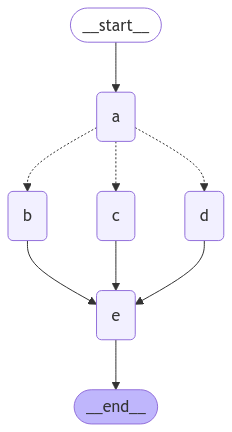

In [23]:
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.9))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.1))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.3))
builder.add_node("e", aggregate_fanout_values)

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route_bc_or_cd, ["b", "c", "d"])
builder.add_edge("b", "e")
builder.add_edge("c", "e")
builder.add_edge("d", "e")
builder.add_edge("e", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to ["I'm A"] in parallel.
Adding I'm C to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm B"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'bc'}

In [25]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to ["I'm A"] in parallel.
Adding I'm D to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm D"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'cd'}